<a href="https://colab.research.google.com/github/nghiaphan177/CS232.K21/blob/master/Keras_CNN_Dog_or_Cat_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Thêm drive vào colab
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Import Thư Viện 

In [95]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
import zipfile
print(os.listdir("/content/drive/My Drive/dog-cat"))


['test1.zip', 'train.zip', 'sampleSubmission.csv']


# Định nghĩa Constants

In [96]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

# Chuẩn bị Traning Data

In [74]:
local_zip = '/content/drive/My Drive/dog-cat/train.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall(".")
zip_ref.close()

In [97]:
filenames = os.listdir("/content/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [98]:
df.head()

,filename,category
0,dog.10375.jpg,1
1,dog.5628.jpg,1
2,dog.6598.jpg,1
3,dog.6259.jpg,1
4,cat.7533.jpg,0


In [99]:
df.tail()

,filename,category
24995,cat.6198.jpg,0
24996,cat.8188.jpg,0
24997,dog.6489.jpg,1
24998,dog.2958.jpg,1
24999,dog.2919.jpg,1


### Xem tổng số 

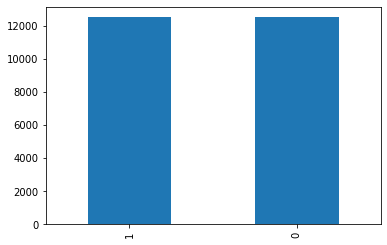

In [100]:
df['category'].value_counts().plot.bar()

Data chúng ta có 12500 cats và 12500 dogs

# Xem ảnh mẫu 






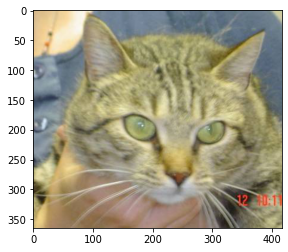

In [101]:
sample = random.choice(filenames)
image = load_img("/content/train/"+sample)
plt.imshow(image)

# Xây dựng Model

<img src="![image.png]()https://i.imgur.com/ebkMGGu.jpg" width="100%"/>

* **Input Layer**: Nó đại diện cho dữ liệu đầu vào. Nó sẽ định hình lại hình ảnh thành mảng 1 chiều duy nhất. Ví dự như hình ảnh đầu vào là 64x64 = 4096, nó sẽ chuyển đổi thành mảng (4096,1) .
* **Conv Layer**: This layer will extract features from image.
* **Pooling Layer**: This layerreduce the spatial volume of input image after convolution.
* **Fully Connected Layer**: It connect the network from a layer to another layer
* **Output Layer**: Đây là lớp giá trị dữ đoán. 


In [102]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 bởi vì chúng ta có 2 lớp dog and cat

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_17 (Batc (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_18 (Batc (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 30, 30, 64)       

# Callbacks

In [103]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [104]:
earlystop = EarlyStopping(patience=10)

**Giảm Learning Rate**

Chúng ta sẽ giảm learning rate nếu accuracy không tăng trong 2 steps.

In [105]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [106]:
callbacks = [earlystop, learning_rate_reduction]

# Chuẩn bị data

Bởi vì sẽ sử dụng trình tạo hình ảnh với class_mode = "phân loại". Chúng ta cần chuyển đổi thể loại cột thành chuỗi. Sau đó, imagerenator sẽ chuyển đổi nó one-hot encoding, tốt cho việc phân loại.

Vì vậy, chúng ta sẽ chuyển đổi 1 thành chó và 0 thành mèo

In [107]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

In [108]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

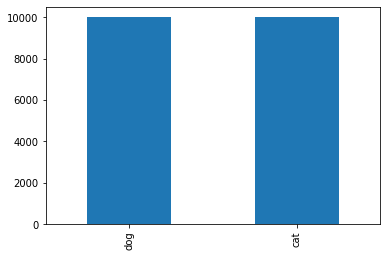

In [109]:
train_df['category'].value_counts().plot.bar()

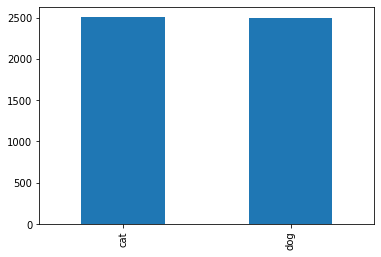

In [110]:
validate_df['category'].value_counts().plot.bar()

In [111]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

# Traning Generator

In [112]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "/content/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


### Validation Generator

In [113]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "/content/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


# Generator làm việc như thế nào

In [114]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "/content/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


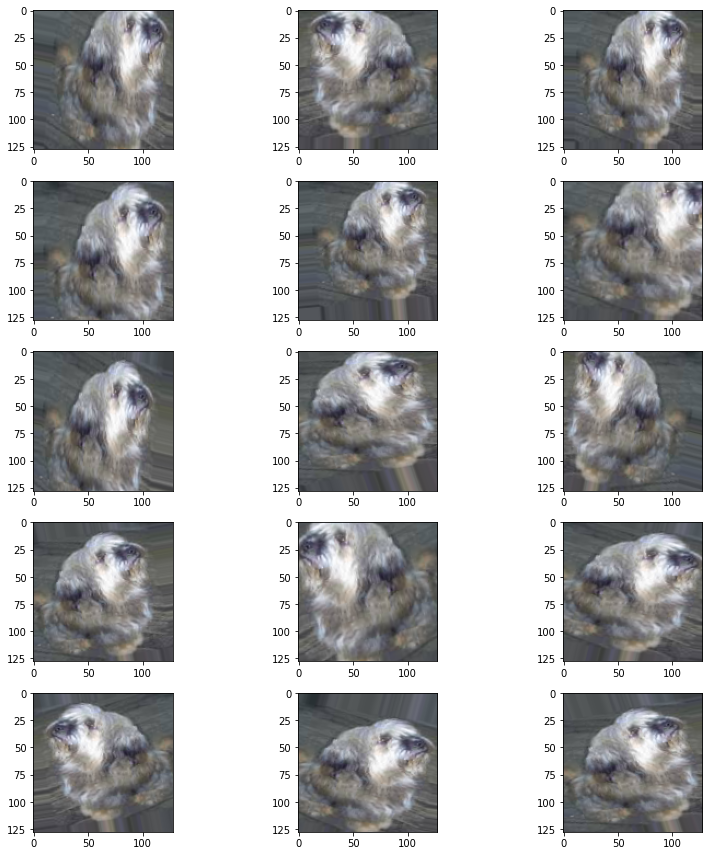

In [115]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

# Fit Model

In [116]:
epochs=50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/50
1333/1333 [==============================] - 146s 110ms/step - loss: 0.7406 - accuracy: 0.6457 - val_loss: 0.5966 - val_accuracy: 0.7351
Epoch 2/50
1333/1333 [==============================] - 146s 110ms/step - loss: 0.5388 - accuracy: 0.7383 - val_loss: 0.6035 - val_accuracy: 0.6971
Epoch 3/50
1333/1333 [==============================] - 146s 109ms/step - loss: 0.4850 - accuracy: 0.7714 - val_loss: 0.8070 - val_accuracy: 0.7115

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 4/50
1333/1333 [==============================] - 145s 109ms/step - loss: 0.4209 - accuracy: 0.8089 - val_loss: 0.3741 - val_accuracy: 0.7581
Epoch 5/50
1333/1333 [==============================] - 144s 108ms/step - loss: 0.4041 - accuracy: 0.8173 - val_loss: 0.4386 - val_accuracy: 0.7918
Epoch 6/50
1333/1333 [==============================] - 144s 108ms/step - loss: 0.3823 - accuracy: 0.8306 - val_loss: 0.1878 - val_accuracy: 0.8335
Epoch 7/50
1333/1333 [=========

# Lưu Model

In [117]:
model.save_weights("model.h5")

# Virtualize Training

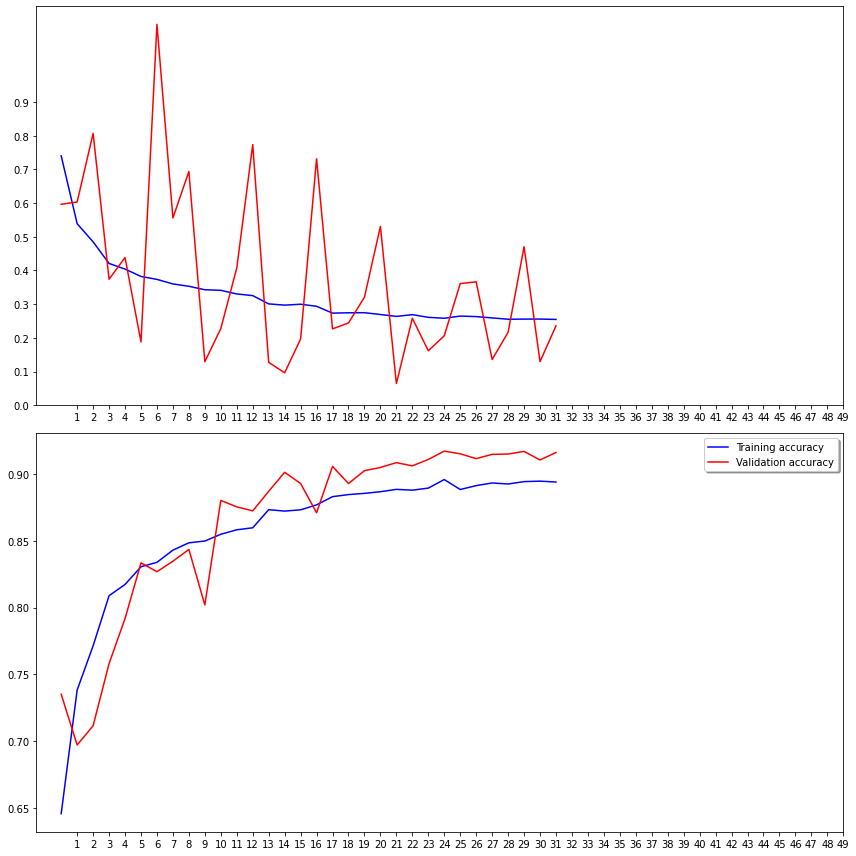

In [118]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# Chuẩn bị dữ liệu test

In [121]:
local_zip = '/content/drive/My Drive/dog-cat/test1.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall(".")
zip_ref.close()

In [122]:
test_filenames = os.listdir("/content/test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

#Tạo Testing Generator

In [123]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "/content/test1/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 12500 validated image filenames.


#Dự đoán test

In [124]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

For categoral classication the prediction will come with probability of each category. So we will pick the category that have the highest probability with numpy average max

In [125]:
test_df['category'] = np.argmax(predict, axis=-1)

We will convert the predict category back into our generator classes by using train_generator.class_indices. It is the classes that image generator map while converting data into computer vision

In [126]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

From our prepare data part. We map data with {1: 'dog', 0: 'cat'}. Now we will map the result back to dog is 1 and cat is 0

In [127]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

**Virtaulize Kết quả test**

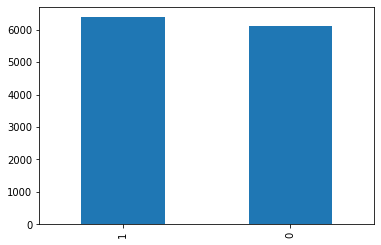

In [128]:
test_df['category'].value_counts().plot.bar()

**Hiển thị một số kết quả test**

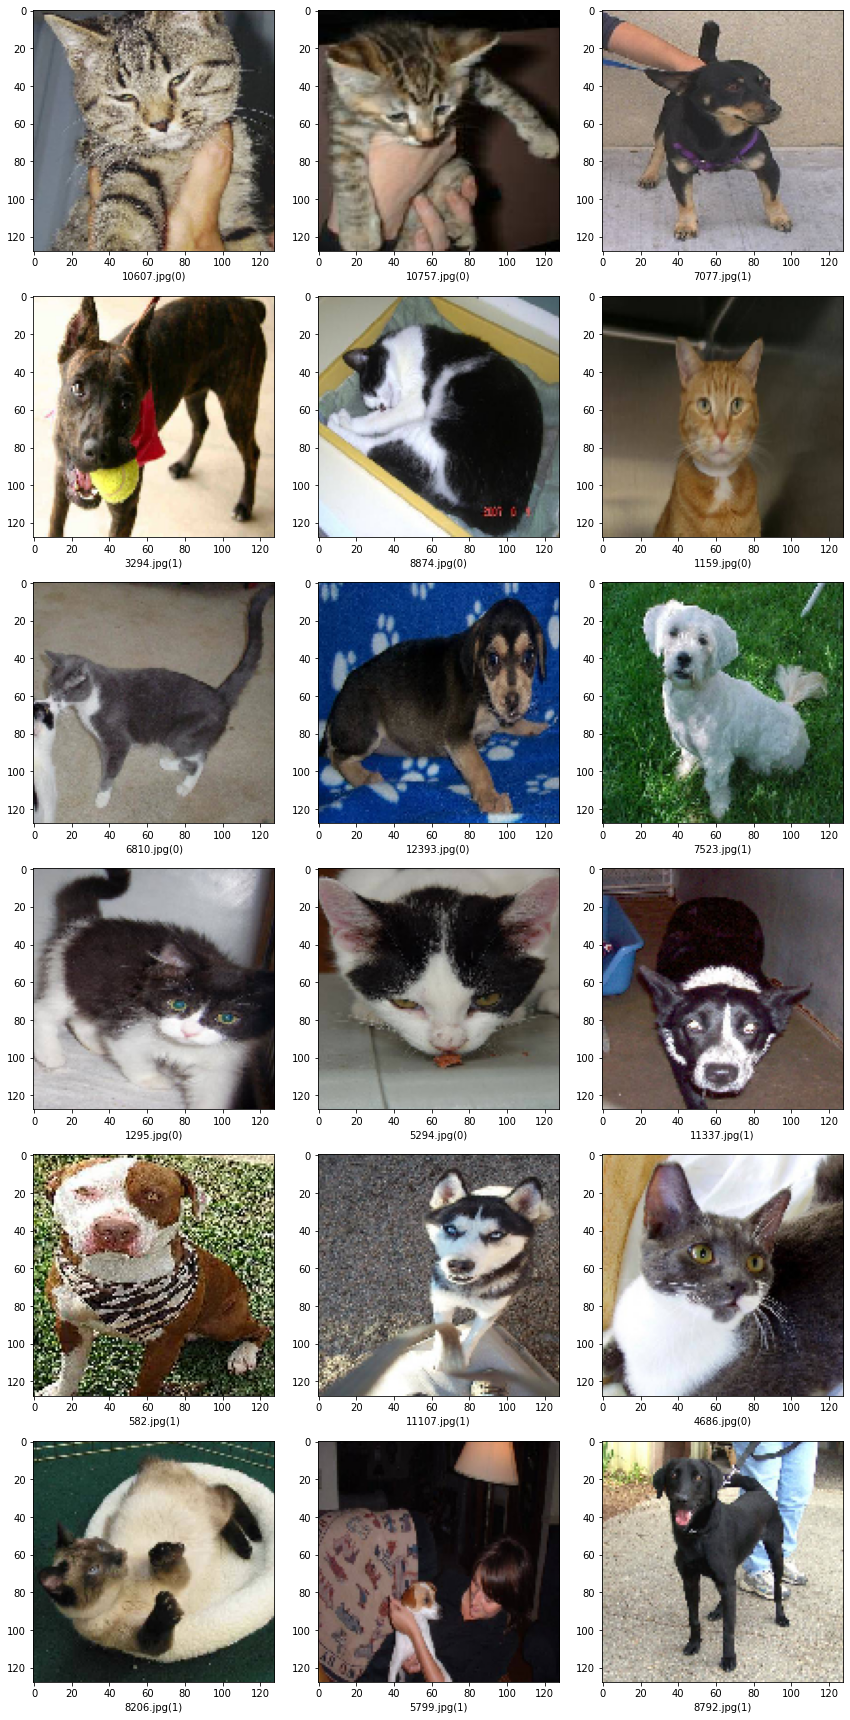

In [129]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("/content/test1/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

# Dự đoán với hình ảnh nhập vào

0 cat


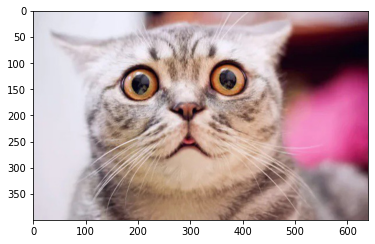

In [162]:
results={
    0:'cat',
    1:'dog'
}
from keras.preprocessing import image
import PIL
from PIL import Image
import numpy as np
im=image.load_img("/content/meo1.jpg")
plt.imshow(im)
im=im.resize(IMAGE_SIZE)
im=np.expand_dims(im,axis=0)
im=np.array(im)
im=im/255
pred=model.predict_classes([im])[0]
print(pred,results[pred])